In [134]:
# The rest of the modules are loaded when required.
# To ensure a standalone character (for easier reusability).

import os # for detecting CPU cores
import configparser # to load standard config and parameters
import pandas as pd
import numpy as np
import warnings

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.express as px

# Debugging
from icecream import ic

warnings.filterwarnings('ignore')
%load_ext watermark
%matplotlib inline

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [135]:
# importing the tensorflow package
import tensorflow as tf

# Checking GPU support
print(tf.test.is_built_with_cuda()) # True
print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)) # True
print(tf.config.list_physical_devices('GPU'))

True
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [136]:
import os
import configparser

# Load external config file
config = configparser.ConfigParser()
config.read("../resources/config.ini")

PATH_DATA_RAW = config["PATHS"]["PATH_DATA_RAW"]
PATH_DATA_INT = config["PATHS"]["PATH_DATA_INT"]
PATH_DATA_PRO = config["PATHS"]["PATH_DATA_PRO"]
PATH_REPORTS = config["PATHS"]["PATH_REPORTS"]
PATH_MODELS = config["PATHS"]["PATH_MODELS"]
PATH_SUB = config["PATHS"]["PATH_SUB"]

# Telegram Bot
token = config["TELEGRAM"]["token"]
chat_id = config["TELEGRAM"]["chat_id"]
FILENAME_NB = "02_baseline_models" # for Telegram messages

# Set global randome state
rnd_state = 42

# Define available cpu cores
n_cpu = os.cpu_count()
print("Number of CPUs used:", n_cpu)

Number of CPUs used: 16


In [137]:
train_df = pd.read_csv(PATH_DATA_RAW+'train.csv',index_col=0)
test_df = pd.read_csv(PATH_DATA_RAW+'test.csv',index_col=0)
sample_df = pd.read_csv(PATH_DATA_RAW+'sample_submission.csv')

In [138]:
train_df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f276,f277,f278,f279,f280,f281,f282,f283,f284,target
id,,,,,,,,,,,,,,,,,,,,,
0,0.205979,0.410993,0.176775,0.223581,0.423543,0.476140,0.413590,0.612021,0.534873,0.147295,...,0,1,0,0,0,0,0,0,0,1
1,0.181004,0.473119,0.011734,0.213657,0.619678,0.441593,0.230407,0.686013,0.281971,0.238509,...,0,1,0,0,0,0,0,0,0,1
2,0.182583,0.307431,0.325950,0.207116,0.605699,0.309695,0.493337,0.751107,0.536272,0.286813,...,0,0,0,1,1,0,0,0,0,1
3,0.180240,0.494592,0.008367,0.223580,0.760618,0.439211,0.432055,0.776147,0.483958,0.260886,...,0,0,0,0,1,0,0,0,0,1
4,0.177172,0.495513,0.014263,0.548819,0.625396,0.562493,0.117158,0.561255,0.077115,0.158321,...,0,1,1,0,1,0,0,1,0,1


In [139]:
memory_usage = train_df.memory_usage(deep=True) / 1024 ** 2
start_mem = memory_usage.sum()
start_mem

2189.63623046875

In [140]:
feature_cols = train_df.drop(['target'], axis=1).columns.tolist()
cnt_features = train_df.drop(['target'], axis=1).select_dtypes(exclude=['int64']).columns.tolist()
cat_features = train_df.drop(['target'], axis=1).select_dtypes(exclude=['float64']).columns.tolist()

ic(len(feature_cols))
ic(len(cnt_features))
ic(len(cat_features));

ic| len(feature_cols): 285
ic| len(cnt_features): 240
ic| len(cat_features): 45


In [141]:
#useful_features = useful_features = ["f22", "f179", "f69", "f58", "f214", "f78", "f136", "f156", "f8", "f3", "f77", "f200", "f92", "f185", "f142", "f115", "f284"]
useful_features = pd.read_csv(PATH_DATA_INT+'features_selected_6way_140.csv')['Feature'].head(13).tolist()
ic(len(useful_features));

ic| len(useful_features): 13


In [142]:
#feature_cols = useful_features

In [143]:
train_df[cnt_features] = train_df[cnt_features].astype('float32')
train_df[cat_features] = train_df[cat_features].astype('uint8')

test_df[cnt_features] = test_df[cnt_features].astype('float32')
test_df[cat_features] = test_df[cat_features].astype('uint8')

In [144]:
memory_usage = train_df.memory_usage(deep=True) / 1024 ** 2
end_mem = memory_usage.sum()
end_mem

973.7014770507812

In [145]:
print("Mem. usage decreased from {:.2f} MB to {:.2f} MB ({:.2f}% reduction)".format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))

Mem. usage decreased from 2189.64 MB to 973.70 MB (55.53% reduction)


# Feature Engineering

## KMeans Clustering

In [146]:
from sklearn.cluster import KMeans

n_clusters_1 = 6
cluster_cols = [f"cluster{i+1}" for i in range(n_clusters_1)]
kmeans = KMeans(n_clusters=n_clusters_1, n_init=50, max_iter=500, random_state=rnd_state)

ic(n_clusters_1)
ic(cluster_cols);

ic| n_clusters_1: 6
ic| cluster_cols: ['cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6']


In [147]:
# cluster distance instead of cluster number

# train
X_cd = kmeans.fit_transform(train_df[useful_features])
X_cd = pd.DataFrame(X_cd, columns=cluster_cols, index=train_df.index)
train = train_df.join(X_cd)

# test
X_cd = kmeans.transform(test_df[useful_features])
X_cd = pd.DataFrame(X_cd, columns=cluster_cols, index=test_df.index)
test = test_df.join(X_cd)

In [148]:
feature_cols += cluster_cols
train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f282,f283,f284,target,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6
id,,,,,,,,,,,,,,,,,,,,,
0,0.205979,0.410993,0.176775,0.223581,0.423543,0.476140,0.413590,0.612021,0.534873,0.147295,...,0,0,0,1,0.189223,1.050896,1.017506,1.130244,0.323917,0.527001
1,0.181004,0.473119,0.011734,0.213657,0.619678,0.441593,0.230407,0.686013,0.281971,0.238509,...,0,0,0,1,0.305138,1.039516,1.045487,1.146268,0.284001,0.559371
2,0.182583,0.307431,0.325950,0.207116,0.605699,0.309695,0.493337,0.751107,0.536272,0.286813,...,0,0,0,1,1.115489,0.556324,0.493650,0.182968,1.144580,1.016904
3,0.180240,0.494592,0.008367,0.223580,0.760618,0.439211,0.432055,0.776147,0.483958,0.260886,...,0,0,0,1,0.203052,1.052789,1.020134,1.137029,0.329684,0.541285
4,0.177172,0.495513,0.014263,0.548819,0.625396,0.562493,0.117158,0.561255,0.077115,0.158321,...,0,1,0,1,1.119016,0.569530,0.502388,0.703449,1.150751,1.221849


In [149]:
ic(len(feature_cols))
#ic(feature_cols);

ic| len(feature_cols): 291


291

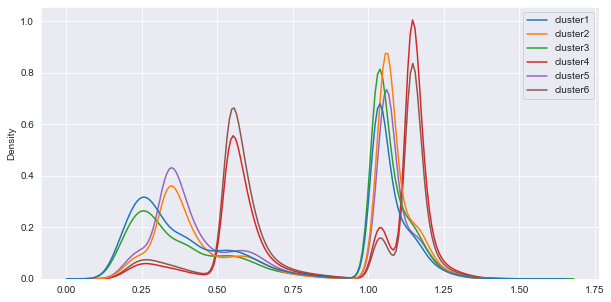

In [150]:
sns.set_style('darkgrid')
fig = plt.figure(figsize = (10,5))
sns.kdeplot(data=train[cluster_cols])
plt.show()

## PCA

In [151]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(train[useful_features])
T_pca = pca.transform(test[useful_features])

pca_cols = [f"PC{i+1}" for i in range(X_pca.shape[1])]

X_pca = pd.DataFrame(X_pca, columns=pca_cols, index=train.index)
T_pca = pd.DataFrame(T_pca, columns=pca_cols, index=test.index)

train = pd.concat([train, X_pca], axis=1)
test = pd.concat([test, T_pca], axis=1)

In [152]:
train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
id,,,,,,,,,,,,,,,,,,,,,
0,0.205979,0.410993,0.176775,0.223581,0.423543,0.476140,0.413590,0.612021,0.534873,0.147295,...,-0.075919,0.072574,-0.078816,0.042145,-0.048512,0.050377,0.007353,-0.075607,-0.056399,-0.022955
1,0.181004,0.473119,0.011734,0.213657,0.619678,0.441593,0.230407,0.686013,0.281971,0.238509,...,0.044755,-0.194861,-0.122842,-0.067265,-0.011181,0.027407,0.029055,-0.042638,-0.067769,-0.021045
2,0.182583,0.307431,0.325950,0.207116,0.605699,0.309695,0.493337,0.751107,0.536272,0.286813,...,-0.071592,0.083183,0.033094,-0.055568,0.016739,-0.002358,-0.036986,-0.038486,-0.071907,-0.018712
3,0.180240,0.494592,0.008367,0.223580,0.760618,0.439211,0.432055,0.776147,0.483958,0.260886,...,0.021852,0.027427,0.085082,-0.052569,-0.067050,0.143113,-0.036925,0.004678,-0.057839,-0.020637
4,0.177172,0.495513,0.014263,0.548819,0.625396,0.562493,0.117158,0.561255,0.077115,0.158321,...,-0.084260,-0.377607,0.061325,0.123573,-0.043745,0.029382,-0.054322,-0.034968,0.269221,-0.029587


In [153]:
loadings = pd.DataFrame(pca.components_, index=pca_cols, columns=train[useful_features].columns)
loadings.style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

,f92,f8,f78,f77,f69,f58,f3,f22,f214,f179,f156,f136,f12
PC1,0.000257,0.001003,-0.001392,-0.000108,-0.000680,-0.000590,0.000160,-0.999990,-0.000870,-0.001292,0.003640,0.000536,-0.000249
PC2,0.004515,-0.000783,0.000233,-0.002175,0.001173,-0.001857,0.002602,-0.003646,0.004225,0.002039,-0.999958,-0.002608,-0.002080
PC3,0.004003,0.021088,0.001807,-0.003124,0.000340,0.186397,-0.002385,-0.000955,0.982074,0.016587,0.003853,-0.004067,0.000309
PC4,-0.007635,0.046828,0.012945,0.006710,0.002397,0.981029,0.003892,-0.000405,-0.187236,0.004732,-0.002664,-0.000138,-0.003338
PC5,-0.084278,0.994764,0.016988,-0.010366,-0.001089,-0.050525,-0.004948,0.000991,-0.011509,0.000840,-0.001071,-0.000465,-0.015197
PC6,-0.995668,-0.084466,-0.006173,-0.017002,0.002363,-0.002055,-0.010006,-0.000314,0.006743,-0.031707,-0.004448,-0.001041,0.000796
PC7,-0.031562,-0.003965,-0.002621,0.002441,0.000193,-0.007730,-0.003710,-0.001280,-0.015222,0.999312,0.001840,-0.004445,0.004503
PC8,-0.004694,-0.017788,0.999475,-0.005091,0.009025,-0.012180,0.008109,-0.001412,0.000849,0.002298,0.000252,0.005225,0.018829
PC9,-0.017926,0.008463,0.004862,0.998680,0.028874,-0.006831,0.032444,-0.000127,0.004469,-0.002772,-0.002072,-0.003751,-0.015587
PC10,0.002902,-0.002777,-0.004382,-0.031735,0.969880,-0.002731,-0.000882,-0.000591,0.000140,0.000969,0.001760,-0.011506,-0.241132


In [154]:
#feature_cols += ["PC1"]
feature_cols += pca_cols


## Polynomial Features **Test**

- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [155]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True)

X_poly = poly.fit_transform(train[useful_features])
T_poly = poly.transform(test[useful_features])

poly_cols = [f"poly{i+1}" for i in range(X_poly.shape[1])]

X_poly_df = pd.DataFrame(X_poly, columns=poly_cols, index=train.index)
T_poly_df = pd.DataFrame(T_poly, columns=poly_cols, index=test.index)

train = pd.concat([train, X_poly_df], axis=1)
test = pd.concat([test, T_poly_df], axis=1)


In [156]:
#feature_cols += ["poly79", "poly82", "poly66", "poly32", "poly81", "poly80", "poly42", "poly78", "poly59"]
feature_cols += poly_cols
train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,poly83,poly84,poly85,poly86,poly87,poly88,poly89,poly90,poly91,poly92
id,,,,,,,,,,,,,,,,,,,,,
0,0.205979,0.410993,0.176775,0.223581,0.423543,0.476140,0.413590,0.612021,0.534873,0.147295,...,0.000787,0.006034,0.005739,0.001402,0.097495,0.092744,0.022657,0.711093,0.173718,0.165252
1,0.181004,0.473119,0.011734,0.213657,0.619678,0.441593,0.230407,0.686013,0.281971,0.238509,...,0.001335,0.142616,0.135024,0.038148,0.007033,0.006659,0.001881,0.711160,0.200923,0.190226
2,0.182583,0.307431,0.325950,0.207116,0.605699,0.309695,0.493337,0.751107,0.536272,0.286813,...,0.000124,0.004402,0.008972,0.002714,0.004543,0.009260,0.002802,0.329093,0.099566,0.202945
3,0.180240,0.494592,0.008367,0.223580,0.760618,0.439211,0.432055,0.776147,0.483958,0.260886,...,0.000134,0.009039,0.008477,0.002975,0.011288,0.010587,0.003716,0.716769,0.251562,0.235928
4,0.177172,0.495513,0.014263,0.548819,0.625396,0.562493,0.117158,0.561255,0.077115,0.158321,...,0.000735,0.003362,0.003200,0.001033,0.163017,0.155140,0.050080,0.709660,0.229082,0.218014


## Add New Features

In [157]:
def add_feature(df):
    df["new_f1"] = df["cluster1"]/df["cluster3"]
    df["new_f2"] = df["cluster5"]/df["cluster6"]
    df["new_f3"] = df["cluster5"]/df["cluster2"]
    df["new_f4"] = df["cluster6"]/df["cluster4"]
    return df

new_features = ["new_f1", "new_f2", "new_f3","new_f4"]
train = add_feature(train)
test = add_feature(test)
feature_cols += new_features
train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,poly87,poly88,poly89,poly90,poly91,poly92,new_f1,new_f2,new_f3,new_f4
id,,,,,,,,,,,,,,,,,,,,,
0,0.205979,0.410993,0.176775,0.223581,0.423543,0.476140,0.413590,0.612021,0.534873,0.147295,...,0.097495,0.092744,0.022657,0.711093,0.173718,0.165252,0.185968,0.614641,0.308229,0.466272
1,0.181004,0.473119,0.011734,0.213657,0.619678,0.441593,0.230407,0.686013,0.281971,0.238509,...,0.007033,0.006659,0.001881,0.711160,0.200923,0.190226,0.291862,0.507715,0.273205,0.487993
2,0.182583,0.307431,0.325950,0.207116,0.605699,0.309695,0.493337,0.751107,0.536272,0.286813,...,0.004543,0.009260,0.002802,0.329093,0.099566,0.202945,2.259678,1.125554,2.057399,5.557831
3,0.180240,0.494592,0.008367,0.223580,0.760618,0.439211,0.432055,0.776147,0.483958,0.260886,...,0.011288,0.010587,0.003716,0.716769,0.251562,0.235928,0.199044,0.609076,0.313153,0.476052
4,0.177172,0.495513,0.014263,0.548819,0.625396,0.562493,0.117158,0.561255,0.077115,0.158321,...,0.163017,0.155140,0.050080,0.709660,0.229082,0.218014,2.227395,0.941811,2.020525,1.736941


## Mutual Information

In [158]:
from sklearn.feature_selection import mutual_info_regression

x = train.iloc[:50000,:][feature_cols] #.copy()
y = train.iloc[:50000,:]['target'] #.copy()
mi_scores = mutual_info_regression(x, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=x.columns)
mi_scores = mi_scores.sort_values(ascending=False)

In [159]:
import plotly.figure_factory as ff
import plotly.express as px

top = 20
fig = px.bar(mi_scores, x=mi_scores.values[:top], y=mi_scores.index[:top])
fig.update_layout(
    title=f"Top {top} Strong Relationships Between Feature Columns and Target Column",
    xaxis_title="Relationship with Target",
    yaxis_title="Feature Columns",
    yaxis={'categoryorder':'total ascending'},
    colorway=["blue"]
)
fig.show()

In [160]:
ic(len(feature_cols))

ic| len(feature_cols): 400


400

# Baseline Score

In [161]:
"""
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X = train_df.drop(["target"], axis=1)
y = train_df["target"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=rnd_state, stratify=y
)

params = {
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "tree_method": "gpu_hist",
    "gpu_id": 0,
    #"n_jobs": n_cpu,
    "predictor": "gpu_predictor",
    "n_estimators": 10000,
    "learning_rate": 0.01063045229441343,
    "gamma": 0.24652519525750877,
    "max_depth": 4,
    "seed": rnd_state,
    "min_child_weight": 366,
    "subsample": 0.6423040816299684,
    "colsample_bytree": 0.7751264493218339,
    "colsample_bylevel": 0.8675692743597421,
    "use_label_encoder": False,
    "lambda": 0,
    "alpha": 10,
}

clf = XGBClassifier(**params)
_ = clf.fit(X_train, y_train)

train_roc_auc_score = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
valid_roc_auc_scoce = roc_auc_score(y_valid, clf.predict_proba(X_valid)[:, 1])

print(train_roc_auc_score) # 0.8617102921465771 (fs18, no_new_f), same with fs16, and 3 new_f
print(valid_roc_auc_scoce) # 0.8558234199478256 (fs18, no_new_f), same with fs16, and 3 new_f
"""


'\nfrom xgboost import XGBClassifier\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import roc_auc_score\n\nX = train_df.drop(["target"], axis=1)\ny = train_df["target"]\n\nX_train, X_valid, y_train, y_valid = train_test_split(\n    X, y, test_size=0.25, random_state=rnd_state, stratify=y\n)\n\nparams = {\n    "eval_metric": "auc",\n    "objective": "binary:logistic",\n    "tree_method": "gpu_hist",\n    "gpu_id": 0,\n    #"n_jobs": n_cpu,\n    "predictor": "gpu_predictor",\n    "n_estimators": 10000,\n    "learning_rate": 0.01063045229441343,\n    "gamma": 0.24652519525750877,\n    "max_depth": 4,\n    "seed": rnd_state,\n    "min_child_weight": 366,\n    "subsample": 0.6423040816299684,\n    "colsample_bytree": 0.7751264493218339,\n    "colsample_bylevel": 0.8675692743597421,\n    "use_label_encoder": False,\n    "lambda": 0,\n    "alpha": 10,\n}\n\nclf = XGBClassifier(**params)\n_ = clf.fit(X_train, y_train)\n\ntrain_roc_auc_score = roc_auc_score(y_train

# Creating Kfolds

In [162]:
from sklearn.model_selection import StratifiedKFold

folds = 5
train["kfold"] = -1
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=rnd_state)

# Adding folds to dataset
for fold, (train_indicies, valid_indicies) in enumerate(kf.split(train,train["target"])):
    train.loc[valid_indicies, "kfold"] = fold

In [163]:
train['kfold'].value_counts()

3    200000
2    200000
4    200000
0    200000
1    200000
Name: kfold, dtype: int64

In [164]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import time

final_test_predictions = []
scores = []

for fold in range(folds):
    x_train = train[train.kfold != fold].copy()
    x_valid = train[train.kfold == fold].copy()
    x_test = test[feature_cols].copy()

    y_train = x_train["target"]
    y_valid = x_valid["target"]

    x_train = x_train[feature_cols]
    x_valid = x_valid[feature_cols]

    xgb_params = {
        "eval_metric": "auc",
        "objective": "binary:logistic",
        "tree_method": "gpu_hist",
        "gpu_id": 0,
        #"n_jobs": n_cpu,
        "predictor": "gpu_predictor",
        "n_estimators": 10000,
        "learning_rate": 0.01063045229441343,
        "gamma": 0.24652519525750877,
        "max_depth": 4,
        "seed": rnd_state,
        "min_child_weight": 366,
        "subsample": 0.6423040816299684,
        "colsample_bytree": 0.7751264493218339,
        "colsample_bylevel": 0.8675692743597421,
        "use_label_encoder": False,
        "lambda": 0,
        "alpha": 10,
    }

    model = XGBClassifier(**xgb_params)
    model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose=False)

    preds_train = model.predict_proba(x_train)[:, 1]
    preds_valid = model.predict_proba(x_valid)[:, 1]
    auc_train = roc_auc_score(y_train, preds_train)
    auc = roc_auc_score(y_valid, preds_valid)
    print("Fold", fold, ", train:", f"{auc_train:.6f}", ", valid:", f"{auc:.6f}")
    scores.append(auc)

    preds_test = model.predict_proba(x_test)[:, 1]
    final_test_predictions.append(preds_test)


print("AVG AUC:", np.mean(scores))

Fold 0 , train: 0.869864 , valid: 0.858313
Fold 1 , train: 0.870426 , valid: 0.855454
Fold 2 , train: 0.870075 , valid: 0.857209
Fold 3 , train: 0.870507 , valid: 0.855764
Fold 4 , train: 0.870189 , valid: 0.856540
AVG AUC: 0.85665603151766


#  Submit results

- 2021-10-20_submission_kmean-pca-fs17-xbg-nop.csv: 0.8569970265985022 | **0.85626**
- 2021-10-20_submission_kmean-3pca-fs17-xbg-nop.csv: 0.8568950821125828 | 0.85619
- 2021-10-20_submission_kmean-ALLpca-fs13-xbg-nop.csv: 0.8567778822323093 | not submitted
- 2021-10-20_submission_13fs-kmean-2pca-4nf-xbg-nop.csv: 0.8568443738048714 | not submitted
- 2021-10-20_submission_49fs-kmean-2pca-4nf-xbg-nop.csv: 0.8567888578426363 | 0.85599
- 2021-10-20_submission_13fs-kmean-1pca-4nf-poly-xbg-nop.csv: 0.8568639280432698 | 0.85615

In [165]:
import numpy as np
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
now = now.strftime("%Y-%m-%d")

objective = "13fs-kmean-FULLpca-4nf-FULLpoly-xbg-nop"

curr_submission_fn = f"{now}_submission_{objective}.csv"

sample_df['target'] = np.mean(np.column_stack(final_test_predictions), axis=1)
#sample_df['target'] = round(sample_df['target'],0)
sample_df.to_csv(PATH_SUB + curr_submission_fn, index=False)

print(curr_submission_fn)


2021-10-20_submission_13fs-kmean-FULLpca-4nf-FULLpoly-xbg-nop.csv


In [166]:
#!kaggle competitions submit tabular-playground-series-oct-2021 -f {PATH_SUB+curr_submission_fn} -m {curr_submission_fn}